In [1]:
import os, sys, glob
from datetime import datetime
sys.path.insert(0,'/home/wu-jung/code_git/mi-instrument')

from mi.instrument.kut.ek60.ooicore.zplsc_b import *
from concat_raw import *

data_path = '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/'
fname1 = glob.glob(os.path.join(data_path,'OOI-D20150910-T*.raw'))
fname2 = glob.glob(os.path.join(data_path,'OOI-D20170910-T*.raw'))
fname1 = fname1[0]
fname2 = fname2[0]

In [2]:
%matplotlib inline

In [3]:
particle_data1, data_times1, power_data_dict1, freq1, bin_size1, config_header1, config_transducer1 = parse_echogram_file(fname1)

2017-09-14 13:46:00,093 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20150910-T000000.raw'


In [4]:
particle_data2, data_times2, power_data_dict2, freq2, bin_size2, config_header2, config_transducer2 = parse_echogram_file(fname2)

2017-09-14 13:46:02,837 INFO     mi.instrument.kut.ek60.ooicore.zplsc_b Begin processing echogram data: '/media/wu-jung/wjlee_apl_2/ooi_zplsc_600m/OOI-D20170910-T000000.raw'


In [5]:
power_data_dict1[1].shape

(1046, 28725)

In [6]:
power_data_dict2[1].shape

(1072, 5923)

## Uncompensated echogram for 20150910

### 120 kHz

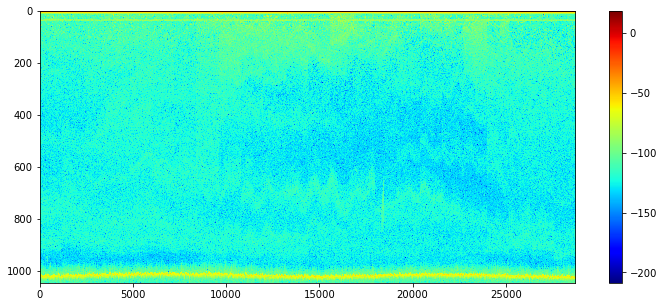

In [7]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[1],aspect='auto',cmap='jet')
plt.colorbar()

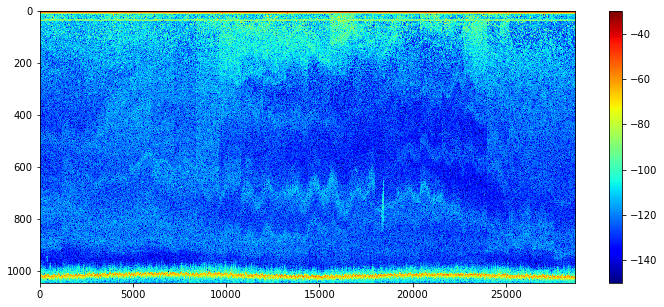

In [8]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[1],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

### 200 kHz

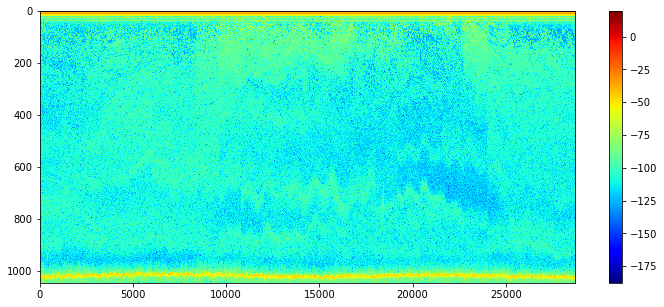

In [9]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[2],aspect='auto',cmap='jet')
plt.colorbar()

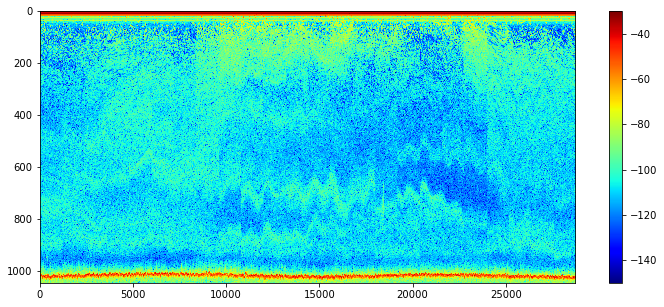

In [10]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict1[2],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

## Uncompensated echogram for 20170910

### 120 kHz

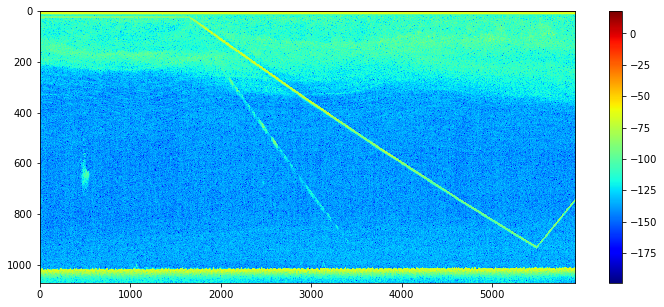

In [11]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[1],aspect='auto',cmap='jet')
plt.colorbar()

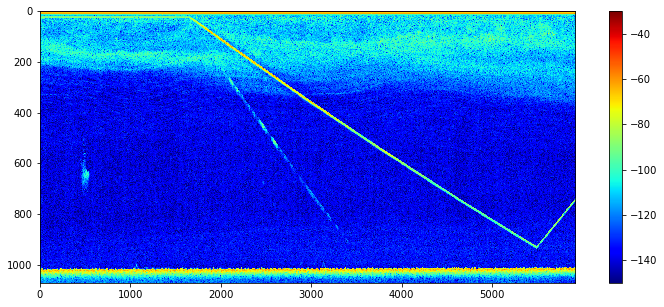

In [12]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[1],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

### 200 kHz

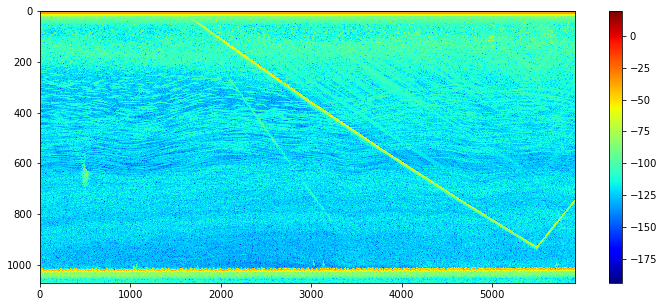

In [13]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[2],aspect='auto',cmap='jet')
plt.colorbar()

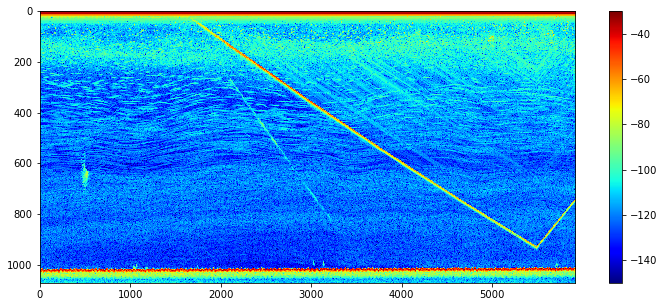

In [14]:
plt.figure(figsize=[12,5])
plt.imshow(power_data_dict2[2],aspect='auto',vmin=-150,vmax=-30,cmap='jet')
plt.colorbar()

## Test implementing De Robertis and Higginbottom 2007 algorithm

In [15]:
power_data_dict1[1].shape

(1046, 28725)

In [16]:
power_data_dict2[1].shape

(1072, 5923)

In [17]:
(bin_size1,bin_size2)

(array([ 0.19121777], dtype=float32), array([ 0.19121777], dtype=float32))

In [66]:
power_data_dict = power_data_dict1
particle_data = particle_data1
config_header = config_header1
config_transducer = config_transducer1

In [76]:
M = 40   # average over M pings
depth_bin_range = 10   # average over depth_bin_range [m]
N1 = int(np.floor(depth_bin_range/bin_size1))
N2 = int(np.floor(depth_bin_range/bin_size2))

In [77]:
tvgCorrectionFactor = 2   # default is to apply TVG correction with offset of 2
                          # note this factor is important in TVG compensation
                          # and therefore in how power_bin is obtained as well

# Average uncompensated power over M pings and N depth bins
depth_bin_num = int(np.floor((power_data_dict[1].shape[0]-tvgCorrectionFactor)/N1))
ping_bin_num = int(np.floor(power_data_dict[1].shape[1]/M))
power_bin = np.empty([depth_bin_num,ping_bin_num])
for iD in range(depth_bin_num):
    for iP in range(ping_bin_num):
        depth_idx = np.arange(N1)+N1*iD+tvgCorrectionFactor  # match the 2-sample offset
        ping_idx = np.arange(M)+M*iP
        power_bin[iD,iP] = np.mean(10**(power_data_dict[1][np.ix_(depth_idx,ping_idx)]/10))

# Noise = minimum value for each averaged ping
noise = np.min(power_bin,0)

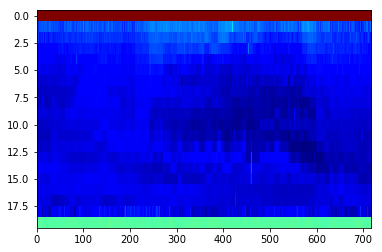

In [78]:
plt.imshow(10*np.log10(power_bin),aspect='auto',cmap='jet')

In [79]:
power_bin.shape

(20, 718)

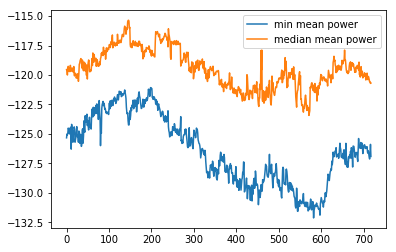

In [81]:
plt.plot(10*np.log10(np.min(power_bin,0)),label='min mean power')
plt.plot(10*np.log10(np.median(power_bin,0)),label='median mean power')
plt.legend()

## Function for noise estimation

In [157]:
def get_noise(power_data,depth_bin_size,ping_bin_range,depth_bin_range,tvgCorrectionFactor=2):
    '''
    INPUT:
        ping_bin_range        average over M pings
        depth_bin_range       average over depth_bin_range [m]
        tvgCorrectionFactor   default (=2) is to apply TVG correction with offset of 2 samples
                              note this factor is important in TVG compensation
                              and therefore in how power_bin is obtained as well
    OUTPUT:
        minimum value for bins of averaged ping
    '''
    N = int(np.floor(depth_bin_range/depth_bin_size))
    
    # Average uncompensated power over M pings and N depth bins
    depth_bin_num = int(np.floor((power_data.shape[0]-tvgCorrectionFactor)/N))
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    power_bin = np.empty([depth_bin_num,ping_bin_num])
    for iD in range(depth_bin_num):
        for iP in range(ping_bin_num):
            depth_idx = np.arange(N)+N*iD+tvgCorrectionFactor  # match the 2-sample offset
            ping_idx = np.arange(ping_bin_range)+ping_bin_range*iP
            power_bin[iD,iP] = np.mean(10**(power_data[np.ix_(depth_idx,ping_idx)]/10))

    # Noise = minimum value for each averaged ping
    return np.min(power_bin,0)

In [125]:
noise_M40 = get_noise(power_data_dict1[1],bin_size1,40,10)

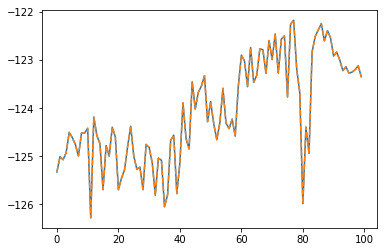

In [126]:
# Check function is doing the right thing
plt.plot(10*np.log10(np.min(power_bin,0))[:100])
plt.plot(10*np.log10(noise_M40)[:100],'--')

## Check influence of ping bin size

### 20150910 120kHz data

In [166]:
M = [1,5,10]+range(20,160,20)
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size2))
noise_stat = np.empty([len(M),2])
for (iM,ping_range_iM) in zip(range(len(M)),M):
    tmp = get_noise(power_data_dict1[1],bin_size1,ping_range_iM,depth_bin_range)
    noise_stat[iM,0] = 10*np.log10(np.mean(tmp))
    noise_stat[iM,1] = np.std(10*np.log10(tmp))

<Container object of 3 artists>

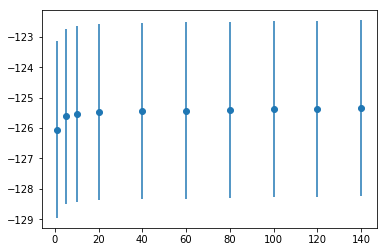

In [167]:
plt.errorbar(M,noise_stat[:,0],noise_stat[:,1],linestyle='None',marker='o')

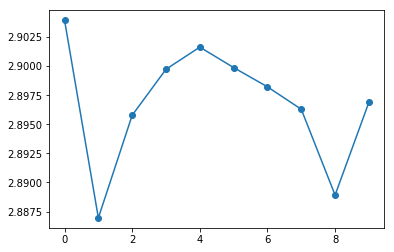

In [168]:
plt.plot(noise_stat[:,1],marker='o')

### Take only a subset of data to check if the high and persistent standard deviation of noise power is resulted from including way too many pings/averaged pings

In [162]:
power_data_dict1_sub = power_data_dict1[1][:,:5923]
M = [1,5,10]+range(20,160,20)
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size2))
noise_stat = np.empty([len(M),2])
for (iM,ping_range_iM) in zip(range(len(M)),M):
    tmp = get_noise(power_data_dict1_sub,bin_size1,ping_range_iM,depth_bin_range)
    noise_stat[iM,0] = 10*np.log10(np.mean(tmp))
    noise_stat[iM,1] = np.std(10*np.log10(tmp))

<Container object of 3 artists>

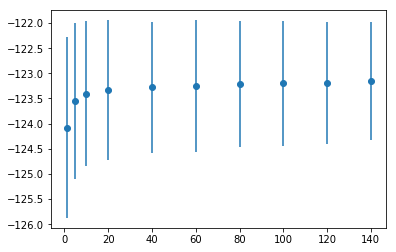

In [163]:
plt.errorbar(M,noise_stat[:,0],noise_stat[:,1],linestyle='None',marker='o')

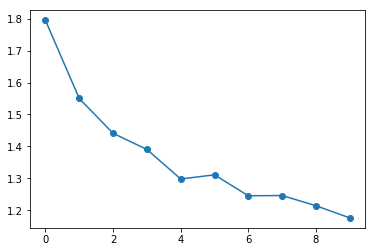

In [165]:
plt.plot(noise_stat[:,1],marker='o')

### 20170910 120kHz data

In [323]:
M = [1,5,10]+range(20,160,20)
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size2))
noise_stat = np.empty([len(M),2])
for (iM,ping_range_iM) in zip(range(len(M)),M):
    tmp = get_noise(power_data_dict2[1],bin_size2,ping_range_iM,depth_bin_range)
    noise_stat[iM,0] = 10*np.log10(np.mean(tmp))
    noise_stat[iM,1] = np.std(10*np.log10(tmp))

<Container object of 3 artists>

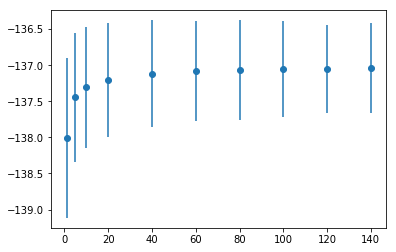

In [324]:
plt.errorbar(M,noise_stat[:,0],noise_stat[:,1],linestyle='None',marker='o')

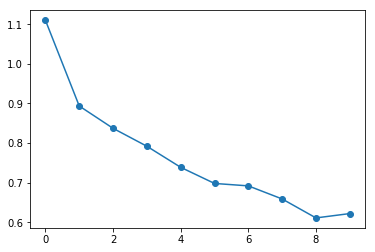

In [325]:
plt.plot(noise_stat[:,1],marker='o')

### The trend of decreasing standard deviation of noise estimate with increasing number of pings averaged shown in Fig.3 of De Robertis and Higginbottom 2007 is only observed when the number of averaged pings included in total are moderate. When there are too many averaged pings, such as in the 20150910 case, the trend is not obvious.

## Noise estimate with TVG and absorption compensation

### 20150910 120 kHz data

In [184]:
n = 0 # firs freq = 120kHz in unpacked format

f = cal_params[n]['frequency']
c = cal_params[n]['soundvelocity']
t = cal_params[n]['sampleinterval']
alpha = cal_params[n]['absorptioncoefficient']
G = cal_params[n]['gain']
phi = cal_params[n]['equivalentbeamangle']
pt = cal_params[n]['transmitpower']
tau = cal_params[n]['pulselength']

dR = c*t/2   # sample thickness
#wvlen = c/f  # wavelength

# determine number of samples in array
pSize = power_data_dict1[n+1].shape   # size(data.pings(n).power);
# create range vector (in m)
range_vec = np.arange(pSize[0]) * dR  # no range correction needed for predicting noise
TVG = np.empty(range_vec.shape)
TVG[range_vec!=0] =  20*np.log10(range_vec[range_vec!=0])  # TVG = real(20*log10(range_vec));
TVG[range_vec==0] = 0

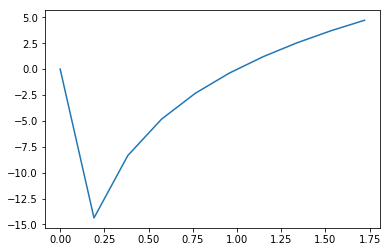

In [187]:
plt.plot(range_vec[:10],TVG[:10])

In [190]:
fn = 1
ping_bin_range = 40   # 40 ping bins
depth_bin_range = 10  # 10m depth bins
N = int(np.floor(depth_bin_range/bin_size1))
noise_est = get_noise(power_data_dict1[fn],bin_size1,ping_bin_range,depth_bin_range)

### Test compensating data

In [322]:
fn = 1
power_data = power_data_dict1[1]


# Get params from cal_params
n = fn-1
f = cal_params[n]['frequency']
c = cal_params[n]['soundvelocity']
t = cal_params[n]['sampleinterval']
alpha = cal_params[n]['absorptioncoefficient']
G = cal_params[n]['gain']
phi = cal_params[n]['equivalentbeamangle']
pt = cal_params[n]['transmitpower']
tau = cal_params[n]['pulselength']

# key derived params
dR = c*t/2   # sample thickness
wvlen = c/f  # wavelength

# Calc gains
CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

# calculate Sa Correction
idx = [i for i,dd in enumerate(cal_params[n]['pulselengthtable']) if dd==tau]
Sac = 2 * cal_params[n]['sacorrectiontable'][idx]

# Get TVG
range_vec = np.arange(power_data.shape[0]) * dR
rangeCorrected = range_vec - (tvg_correction_factor * dR)
rangeCorrected[rangeCorrected<0] = 0

TVG = np.empty(rangeCorrected.shape)
TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
TVG[rangeCorrected==0] = 0

# Get absorption
ABS = 2*alpha*rangeCorrected

# Compensate measurement for noise
ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
Sv_corr = np.empty(power_data.shape)  # log domain corrected Sv
for iP in range(ping_bin_num):
    ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
    tmp_lin = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
    tmp = np.empty(tmp_lin.shape)
    tmp[tmp_lin>0] = 10*np.log10(tmp_lin[tmp_lin>0])
    tmp[tmp_lin<=0] = -999
    #tmp = 10*np.log10( 10**(power_data[:,ping_idx]/10) -noise_est[iP] )    
    Sv_corr[:,ping_idx] = (tmp.T +TVG +ABS -CSv -Sac).T
    
Sv_raw = (power_data.T +TVG +ABS -CSv -Sac).T
    

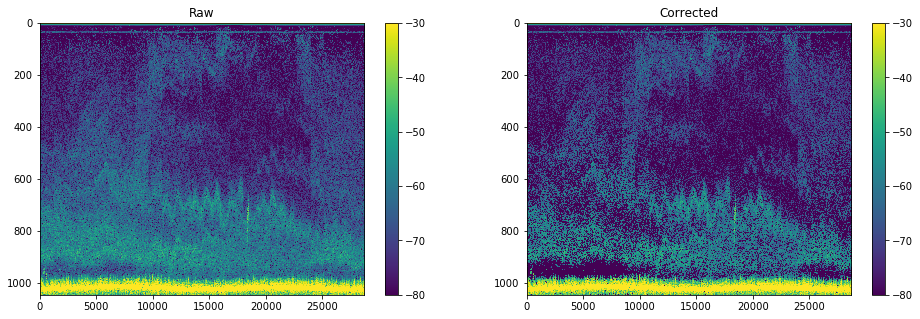

In [314]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(16,5))
im0 = ax0.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected')

### Function to perform noise correction

In [318]:
def remove_noise(power_data,cal,noise_est,ping_bin_range=40,tvg_correction_factor=2):
    '''
    fn      sequence number of that particular freq in power_data
            corresponds to index fn-1 in cal_params
    tvg_correction_factor   default(=2) for converting power_data to Sv
    '''

    # Get cal params
    f = cal['frequency']
    c = cal['soundvelocity']
    t = cal['sampleinterval']
    alpha = cal['absorptioncoefficient']
    G = cal['gain']
    phi = cal['equivalentbeamangle']
    pt = cal['transmitpower']
    tau = cal['pulselength']

    # key derived params
    dR = c*t/2   # sample thickness
    wvlen = c/f  # wavelength

    # Calc gains
    CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))

    # calculate Sa Correction
    idx = [i for i,dd in enumerate(cal['pulselengthtable']) if dd==tau]
    Sac = 2 * cal['sacorrectiontable'][idx]

    # Get TVG
    range_vec = np.arange(power_data.shape[0]) * dR
    rangeCorrected = range_vec - (tvg_correction_factor * dR)
    rangeCorrected[rangeCorrected<0] = 0

    TVG = np.empty(rangeCorrected.shape)
    TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
    TVG[rangeCorrected==0] = 0

    # Get absorption
    ABS = 2*alpha*rangeCorrected

    # Compensate measurement for noise and corrected for transmission loss
    ping_bin_num = int(np.floor(power_data.shape[1]/ping_bin_range))
    Sv_corr = np.empty(power_data.shape)  # log domain corrected Sv
    for iP in range(ping_bin_num):
        ping_idx = np.arange(ping_bin_range) +iP*ping_bin_range
        tmp_lin = 10**(power_data[:,ping_idx]/10) -noise_est[iP]
        tmp = np.empty(tmp_lin.shape)
        tmp[tmp_lin>0] = 10*np.log10(tmp_lin[tmp_lin>0])
        tmp[tmp_lin<=0] = -999
        #tmp = 10*np.log10( 10**(power_data[:,ping_idx]/10) -noise_est[iP] )    
        Sv_corr[:,ping_idx] = (tmp.T +TVG +ABS -CSv -Sac).T

    # Raw measurement corrected for transmission loss
    Sv_raw = (power_data.T +TVG +ABS -CSv -Sac).T
    
    return Sv_corr, Sv_raw

In [320]:
Sv_corr1,Sv_raw1 = remove_noise(power_data_dict1[1],cal_params[0],noise_est,ping_bin_range=40,tvg_correction_factor=2)

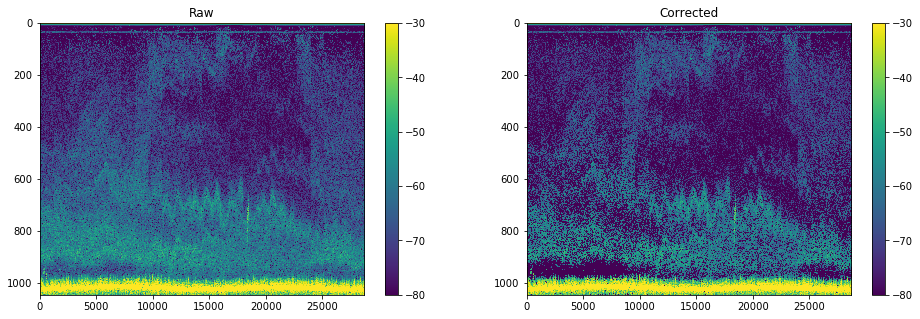

In [321]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(16,5))
im0 = ax0.imshow(Sv_raw,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected')

### Noise compensation for 20170910 data, 120 kHz

In [326]:
noise_est_2017 = get_noise(power_data_dict2[1],bin_size2,ping_bin_range=40,depth_bin_range=10)

In [327]:
cal_params_2017 = get_cal_params(power_data_dict2,particle_data2,config_header2,config_transducer2)

In [329]:
Sv_corr_2017,Sv_raw_2017 = remove_noise(power_data_dict2[1],cal_params_2017[0],noise_est_2017,ping_bin_range=40,tvg_correction_factor=2)

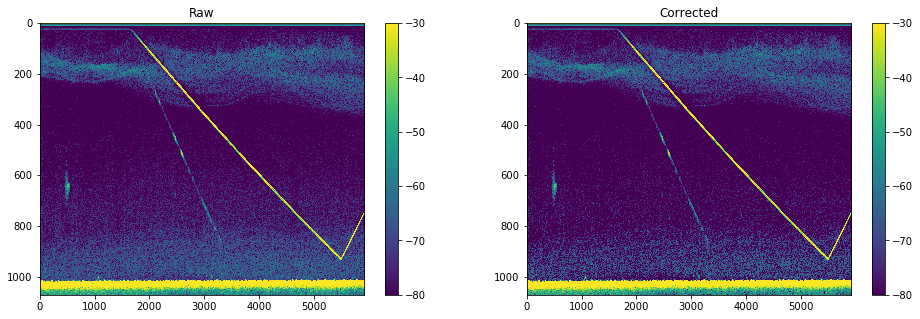

In [330]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(16,5))
im0 = ax0.imshow(Sv_raw_2017,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_2017,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected')

### Noise compensation for 20170910 data, 200 kHz

In [337]:
noise_est_2017 = get_noise(power_data_dict2[3],bin_size2,ping_bin_range=40,depth_bin_range=10)
cal_params_2017 = get_cal_params(power_data_dict2,particle_data2,config_header2,config_transducer2)
Sv_corr_2017,Sv_raw_2017 = remove_noise(power_data_dict2[3],cal_params_2017[2],noise_est_2017,ping_bin_range=40,tvg_correction_factor=2)

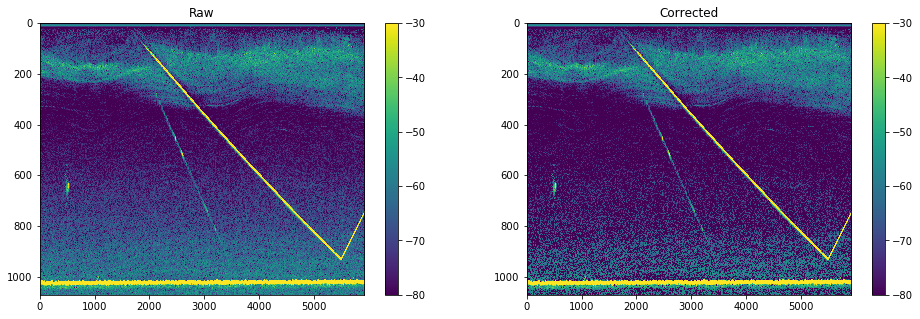

In [343]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(16,5))
im0 = ax0.imshow(Sv_raw_2017,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_2017,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected')

### Noise compensation for 20170910 data, 38 kHz

In [345]:
noise_est_2017 = get_noise(power_data_dict2[2],bin_size2,ping_bin_range=40,depth_bin_range=10)
cal_params_2017 = get_cal_params(power_data_dict2,particle_data2,config_header2,config_transducer2)
Sv_corr_2017,Sv_raw_2017 = remove_noise(power_data_dict2[2],cal_params_2017[1],noise_est_2017,ping_bin_range=40,tvg_correction_factor=2)

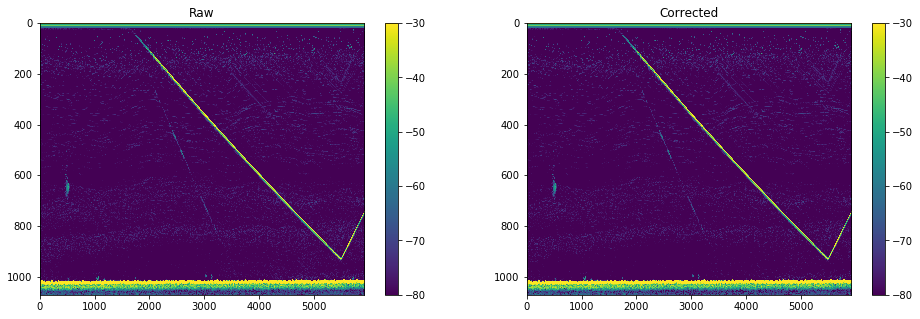

In [346]:
fig,(ax0,ax1) = plt.subplots(ncols=2,figsize=(16,5))
im0 = ax0.imshow(Sv_raw_2017,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im0,ax=ax0)
ax0.set_title('Raw')
im1 = ax1.imshow(Sv_corr_2017,aspect='auto',vmin=-80,vmax=-30)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Corrected')

In [48]:
freq1

{1: 120000.0, 2: 38000.0, 3: 200000.0}

In [42]:
freq2

{1: 120000.0, 2: 38000.0, 3: 200000.0}

In [3]:
data_mtx = get_data_mtx(power_data_dict,freq)

In [4]:
power_data_dict[3].shape

(1046, 28725)

In [5]:
data_mtx.shape

(3, 1046, 28725)

In [6]:
particle_data

(defaultdict(list,
             {'filepath': 'OOI-D20150910-T000000.png',
              'zplsc_absorption_coeff': [0.037440311,
               0.0097852694,
               0.052687589],
              'zplsc_bandwidth': [3026.3916, 2425.1497, 3088.4004],
              'zplsc_channel': [1, 2, 3],
              'zplsc_frequency': [120000.0, 38000.0, 200000.0],
              'zplsc_pulse_length': [0.001024, 0.001024, 0.001024],
              'zplsc_sample_interval': [0.000256, 0.000256, 0.000256],
              'zplsc_sound_velocity': [1493.8888, 1493.8888, 1493.8888],
              'zplsc_temperature': [10.0, 10.0, 10.0],
              'zplsc_timestamp': '20150910000000',
              'zplsc_transducer_depth': [0.0, 0.0, 0.0],
              'zplsc_transmit_power': [250.0, 500.0, 150.0]}),
 3650832000.0861511)

In [7]:
config_header

{'sounder_name': 'ER60',
 'survey_name': 'OOI',
 'transducer_count': 3,
 'transect_name': '',
 'version': '2.4.3'}

In [8]:
config_transducer

[{'angle_offset_alongship': 0.0,
  'angle_offset_athwart': 0.0,
  'angle_sensitivity_alongship': 23.0,
  'angle_sensitivity_athwartship': 23.0,
  'beam_type': 1,
  'beam_width_alongship': 7.0,
  'beam_width_athwartship': 7.0,
  'channel_id': 'GPT 120 kHz 00907208a0b1 3-1 ES120-7CD',
  'dir_x': 0.0,
  'dir_y': 0.0,
  'dir_z': 0.0,
  'equiv_beam_angle': -20.700000762939453,
  'frequency': 120000.0,
  'gain': 25.0,
  'gain_table': array([ 23.5       ,  24.79999924,  25.        ,  25.        ,  25.        ]),
  'gpt_software_version': '070413',
  'pos_x': 0.0,
  'pos_y': 0.0,
  'pos_z': 0.0,
  'pulse_length_table': array([  6.39999998e-05,   1.28000000e-04,   2.55999999e-04,
           5.11999999e-04,   1.02400000e-03]),
  'sa_correction_table': array([ 0.,  0.,  0.,  0.,  0.])},
 {'angle_offset_alongship': 0.0,
  'angle_offset_athwart': 0.0,
  'angle_sensitivity_alongship': 21.899999618530273,
  'angle_sensitivity_athwartship': 21.899999618530273,
  'beam_type': 0,
  'beam_width_alongship

In [9]:
particle_data[0]['zplsc_sound_velocity'][0]

1493.8888

In [10]:
cal_params = get_cal_params(power_data_dict,particle_data,config_header,config_transducer)

In [11]:
cal_params

[{'absorptioncoefficient': 0.037440311,
  'angleoffsetathwartship': 0.0,
  'anglesensitivityalongship': 23.0,
  'anglesensitivityathwartship': 23.0,
  'anglesoffsetalongship': 0.0,
  'equivalentbeamangle': -20.700000762939453,
  'frequency': 120000.0,
  'gain': 25.0,
  'gaintable': array([ 23.5       ,  24.79999924,  25.        ,  25.        ,  25.        ]),
  'pulselength': 0.001024,
  'pulselengthtable': array([  6.39999998e-05,   1.28000000e-04,   2.55999999e-04,
           5.11999999e-04,   1.02400000e-03]),
  'sacorrectiontable': array([ 0.,  0.,  0.,  0.,  0.]),
  'sampleinterval': 0.000256,
  'soundername': 'ER60',
  'soundvelocity': 1493.8888,
  'transducerdepth': 0.0,
  'transmitpower': 250.0},
 {'absorptioncoefficient': 0.0097852694,
  'angleoffsetathwartship': 0.0,
  'anglesensitivityalongship': 21.899999618530273,
  'anglesensitivityathwartship': 21.899999618530273,
  'anglesoffsetalongship': 0.0,
  'equivalentbeamangle': -20.600000381469727,
  'frequency': 38000.0,
  'gai

In [12]:
tvgCorrectionFactor = 2.0

In [13]:
import numpy.matlib

In [14]:
n=0

In [15]:
        Sv_old={}
        f = cal_params[n]['frequency']
        c = cal_params[n]['soundvelocity']
        t = cal_params[n]['sampleinterval']
        alpha = cal_params[n]['absorptioncoefficient']
        G = cal_params[n]['gain']
        phi = cal_params[n]['equivalentbeamangle']
        pt = cal_params[n]['transmitpower']
        tau = cal_params[n]['pulselength']

        dR = c*t/2   # sample thickness
        wvlen = c/f  # wavelength

        # Calc gains
        CSv = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2 * c * tau * 10**(phi/10)) / (32 * np.pi**2))
        CSp = 10 * np.log10((pt * (10**(G/10))**2 * wvlen**2) / (16 * np.pi**2))

        # calculate Sa Correction
        idx = [i for i,dd in enumerate(cal_params[n]['pulselengthtable']) if dd==tau]
        Sac = 2 * cal_params[n]['sacorrectiontable'][idx]

        # determine number of samples in array
        pSize = power_data_dict[n+1].shape   # size(data.pings(n).power);

        # create range vector (in m)
        range_vec = np.arange(pSize[0]) * dR
            # data.pings(n).range = double((0:pSize(1) - 1) + ...
            #    double(data.pings(n).samplerange(1)) - 1)' * dR;

        # apply TVG Range correction -
        rangeCorrected = range_vec - (tvgCorrectionFactor * dR)
        rangeCorrected[rangeCorrected<0] = 0
            # rangeCorrected = data.pings(n).range - (tvgCorrectionFactor * dR);
            # rangeCorrected(rangeCorrected < 0) = 0;

        # update sound speed and absorption coefficient  **** Chu 4/2/2010 ****
        # data.pings(n).absorptioncoefficient(:) = alpha;
        # data.pings(n).soundvelocity(:) = c;

        # Calculate Sv TVG vector - ignore imag components of TVG
        idx_inf = rangeCorrected!=0
        TVG = np.empty(rangeCorrected.shape)
        TVG[rangeCorrected!=0] = np.real( 20*np.log10(rangeCorrected[rangeCorrected!=0]) )  # TVG = real(20 * log10(rangeCorrected));
        TVG[rangeCorrected==0] = 0
        # TVG = real(20 * log10(rangeCorrected));

        Sv_old[n+1] = power_data_dict[n+1] + np.transpose(np.matlib.repmat(TVG,pSize[1],1)) +\
             2*cal_params[n]['absorptioncoefficient']*np.transpose(np.matlib.repmat(rangeCorrected,pSize[1],1)) - CSv - Sac
        Sv_old[n+1] = Sv_old[n+1][::-1]

In [16]:
A=np.transpose(np.matlib.repmat(TVG,pSize[1],1))
A.shape

(1046, 28725)

In [17]:
B=2*cal_params[n]['absorptioncoefficient']*np.transpose(np.matlib.repmat(rangeCorrected,pSize[1],1))
B.shape

(1046, 28725)

In [18]:
%matplotlib inline

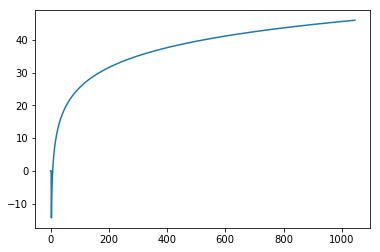

In [19]:
plt.plot(TVG)

In [20]:
        Sv_new = (power_data_dict[n+1].T \
                   +TVG +2*cal_params[n]['absorptioncoefficient']*rangeCorrected\
                   -CSv -Sac).T
        Sv_new = Sv_new[::-1]

In [21]:
power_data_dict[n+1].shape

(1046, 28725)

In [22]:
TVG.shape

(1046,)

In [23]:
rangeCorrected.shape

(1046,)

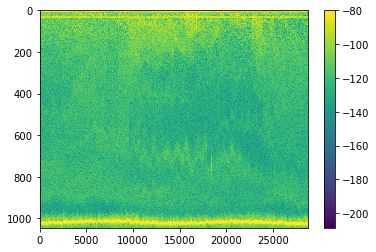

In [24]:
plt.imshow(power_data_dict[1],aspect='auto',vmin=power_data_dict[1].min(),vmax=-80)
plt.colorbar()

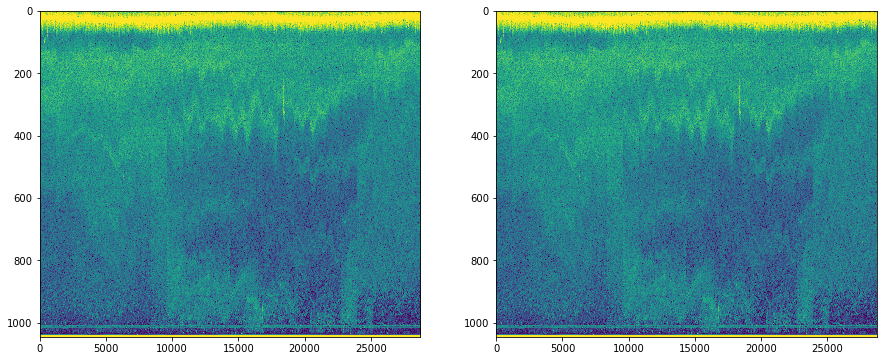

In [25]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(6)
ax[0].imshow(Sv_old[1],aspect='auto',vmin=-100,vmax=-30)
ax[1].imshow(Sv_new,aspect='auto',vmin=-100,vmax=-30)

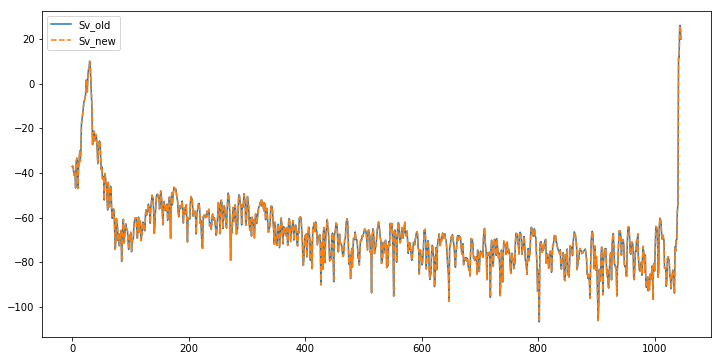

In [35]:
plt.figure(figsize=[12,6])
plt.plot(Sv_old[1][:,10],label='Sv_old')
plt.plot(Sv_new[:,10],'--',label='Sv_new')
plt.legend()

In [26]:
Sv_fcn = power2Sv(power_data_dict,cal_params)  # convert from power to Sv

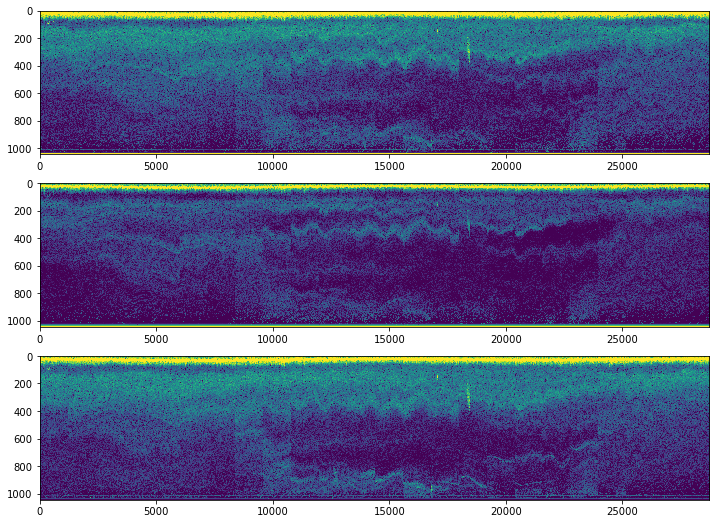

In [27]:
fig,ax = plt.subplots(3,1)
fig.set_figwidth(12)
fig.set_figheight(9)
ax[0].imshow(Sv_fcn[1],aspect='auto',vmin=-80,vmax=-30)
ax[1].imshow(Sv_fcn[2],aspect='auto',vmin=-80,vmax=-30)
ax[2].imshow(Sv_fcn[3],aspect='auto',vmin=-80,vmax=-30)